Must install `imagecodecs` using pip __not__ conda!  (See [this issue](https://github.com/cgohlke/imagecodecs/issues/29))

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from imagecodecs.numcodecs import JpegXl, Jpeg2k, Jpeg
import numcodecs
from numcodecs.registry import register_codec
from pathy import Pathy
import fsspec

plt.rcParams["figure.figsize"] = (20, 12)

In [2]:
SRC_PATH = Pathy("gs://solar-pv-nowcasting-data/prepared_ML_training_data/v15/train/opticalflow")
DST_PATH = Pathy("gs://solar-pv-nowcasting-data/prepared_ML_training_data/v15/train/opticalflow_jpegxl")

In [3]:
src_filenames = list(SRC_PATH.glob("*.nc"))
filename = src_filenames[0]

In [4]:
%%time

def load_dataset(filename, engine="h5netcdf", *args, **kwargs) -> xr.Dataset:
    """Load a NetCDF dataset from local file system or cloud bucket."""
    with fsspec.open(filename, mode="rb") as file:
        dataset = xr.load_dataset(file, engine=engine, *args, **kwargs)
    return dataset

satellite_dataset = load_dataset(filename)

CPU times: user 456 ms, sys: 72 ms, total: 528 ms
Wall time: 1.68 s


In [5]:
satellite_dataset

<xarray.Dataset>
Dimensions:                (example: 32, channels_index: 11, time_index: 24,
                            y_geostationary_index: 24, x_geostationary_index: 24)
Coordinates:
  * channels_index         (channels_index) int64 0 1 2 3 4 5 6 7 8 9 10
  * example                (example) int64 0 1 2 3 4 5 6 ... 26 27 28 29 30 31
  * time_index             (time_index) int64 0 1 2 3 4 5 ... 18 19 20 21 22 23
  * x_geostationary_index  (x_geostationary_index) int64 0 1 2 3 ... 20 21 22 23
    x_osgb                 (example, y_geostationary_index, x_geostationary_index) float32 ...
  * y_geostationary_index  (y_geostationary_index) int64 0 1 2 3 ... 20 21 22 23
    y_osgb                 (example, y_geostationary_index, x_geostationary_index) float32 ...
Data variables:
    channels               (example, channels_index) object 'IR_016' ... 'WV_...
    data                   (example, time_index, y_geostationary_index, x_geostationary_index, channels_index) int16 ...
    time                   (example, time_index) datetime64[ns] 2020-09-12T09...
    x_geostationary        (example, x_geostationary_index) float32 -8.521e+0...
    y_geostationary        (example, y_geostationary_index) float32 4.813e+06...

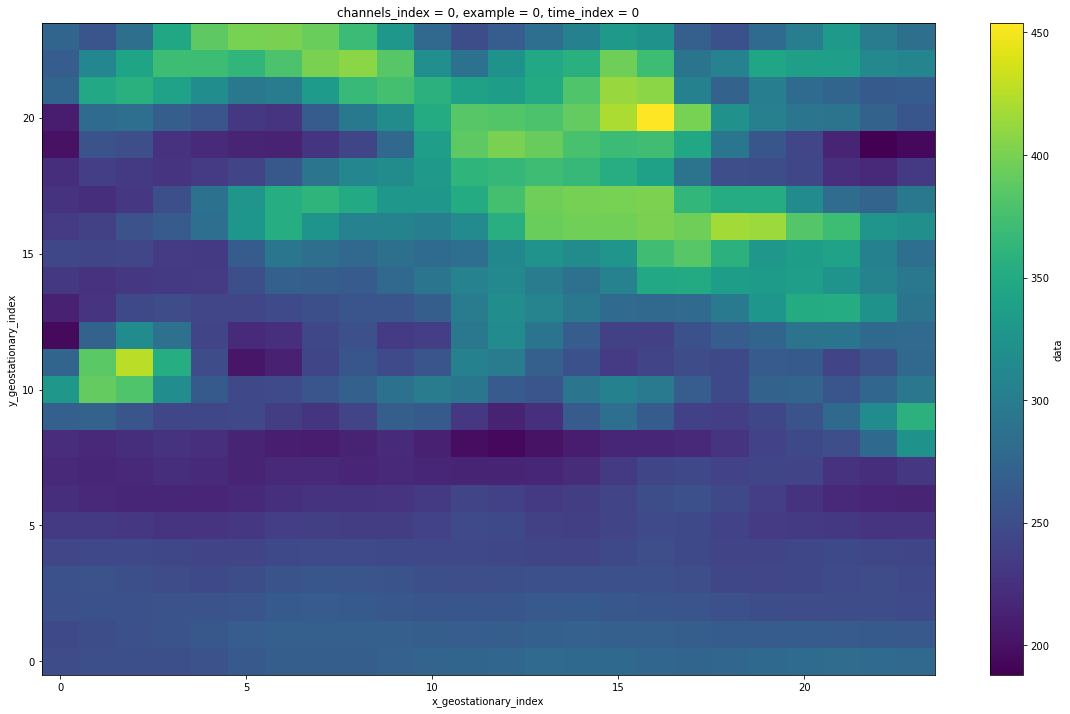

In [6]:
satellite_data_array = satellite_dataset['data']
satellite_data_array.isel(time_index=0, example=0, channels_index=0).plot()

```
$cjxl --help

JPEG XL encoder v0.7.0 7613f62 [AVX2,SSE4,SSSE3,Scalar]
Usage: cjxl INPUT OUTPUT [OPTIONS...]
 INPUT
    the input can be PNG, APNG, GIF, JPEG, EXR, PPM, PFM, or PGX
 OUTPUT
    the compressed JXL output file (can be omitted for benchmarking)
 -d maxError, --distance=maxError
    Max. butteraugli distance, lower = higher quality. Range: 0 .. 25.
    0.0 = mathematically lossless. Default for already-lossy input (JPEG/GIF).
    1.0 = visually lossless. Default for other input.
    Recommended range: 0.5 .. 3.0.
 -q QUALITY, --quality=QUALITY
    Quality setting (is remapped to --distance). Range: -inf .. 100.
    100 = mathematically lossless. Default for already-lossy input (JPEG/GIF).
    Positive quality values roughly match libjpeg quality.
 -e EFFORT, --effort=EFFORT
    Encoder effort setting. Range: 1 .. 9.
    Default: 7. Higher number is more effort (slower).
 -p, --progressive
    Enable progressive/responsive decoding.
 --resampling=0|1|2|4|8
    Subsample all color channels by this factor, or use 0 to choose the resampling factor based on distance.
 -v, --verbose
    Verbose output; can be repeated, also applies to help (!).
 -h, --help
    Prints this help message (use -v to see more options).

```

In [15]:
class JpegXlFuture(JpegXl):
    """Simple hack to make the JpegXl compressor in the currently released
    version of imagecodecs (version 2011.11.20) look like the version in development
    
    See https://github.com/cgohlke/imagecodecs/issues/31#issuecomment-1026179413
    """
    
    codec_id = 'imagecodecs_jpegxl'
    
    def __init__(self, lossless=None, decodingspeed=None, level=None, distance=None, *args, **kwargs):
        """
        Args:
            distance: Lowest settings are 0.00 or 0.01.  If 0.0 then also set lossless to True.
            level: DON'T SET THIS WITH THIS JpegXlFuture wrapper! 
                In imagecodecs version 2011.11.20, level is mapped (incorrectly) to the decoding speed tier. 
                Minimum is 0 (highest quality), and maximum is 4 (lowest quality). Default is 0.
        """
        assert decodingspeed is None
        print(f"{lossless=}")
        if lossless:
            assert distance is None or distance == 0
            assert level is None  # level must be None to enable lossless in imagecodecs 2011.11.20.
        elif lossless is not None:
            level = 0  # level must be set to 0, 1, 2, 3, or 4 to enably lossy compression in imagecodecs 2011.11.20.
        super().__init__(level=level, distance=distance, *args, **kwargs)
        
    def encode(self, buf):
        n_examples = buf.shape[0]
        n_timesteps = buf.shape[1]
        n_channels = buf.shape[-1]
        assert n_examples == 1
        #assert n_timesteps == 1
        assert n_channels == 1
        buf = buf[0]
        return super().encode(buf)
    
    def decode(self, buf, out=None):
        assert out is None
        out = super().decode(buf, out)
        print(f"{out.shape=}")
        out = out[np.newaxis, ...]
        print(f"after new axis: {out.shape=}")        
        return out
        
register_codec(JpegXlFuture)

In [16]:
satellite_dataset["data"] = (satellite_dataset["data"].clip(min=0, max=1023) / 4).round().astype(np.uint8)
satellite_dataset["data"]

<xarray.DataArray 'data' (example: 32, time_index: 24,
                          y_geostationary_index: 24, x_geostationary_index: 24,
                          channels_index: 11)>
array([[[[[16, 50, 40, ..., 20, 32, 22],
          [16, 50, 40, ..., 20, 32, 22],
          [16, 50, 39, ..., 19, 32, 22],
          ...,
          [18, 50, 39, ..., 20, 32, 22],
          [18, 50, 40, ..., 19, 32, 22],
          [17, 50, 40, ..., 19, 32, 22]],

         [[16, 50, 39, ..., 20, 31, 22],
          [16, 50, 39, ..., 20, 32, 22],
          [16, 50, 39, ..., 20, 32, 22],
          ...,
          [16, 50, 40, ..., 20, 33, 22],
          [16, 50, 40, ..., 20, 33, 22],
          [16, 50, 40, ..., 20, 34, 23]],

         [[16, 50, 39, ..., 20, 31, 20],
          [16, 50, 39, ..., 20, 31, 21],
          [16, 50, 38, ..., 20, 31, 21],
          ...,
...
          ...,
          [27, 54, 43, ..., 20, 33, 26],
          [28, 54, 43, ..., 20, 32, 26],
          [28, 52, 43, ..., 19, 34, 27]],

         [[26, 52, 42, ..., 28, 34, 24],
          [24, 52, 42, ..., 28, 34, 25],
          [26, 52, 41, ..., 28, 34, 25],
          ...,
          [22, 55, 44, ..., 23, 34, 26],
          [23, 55, 44, ..., 22, 34, 27],
          [23, 53, 44, ..., 20, 34, 28]],

         [[27, 53, 42, ..., 26, 32, 25],
          [26, 52, 42, ..., 27, 32, 25],
          [27, 52, 41, ..., 29, 33, 26],
          ...,
          [19, 55, 46, ..., 27, 33, 28],
          [19, 54, 47, ..., 26, 34, 28],
          [19, 54, 45, ..., 23, 34, 28]]]]], dtype=uint8)
Coordinates:
  * channels_index         (channels_index) int64 0 1 2 3 4 5 6 7 8 9 10
  * example                (example) int64 0 1 2 3 4 5 6 ... 26 27 28 29 30 31
  * time_index             (time_index) int64 0 1 2 3 4 5 ... 18 19 20 21 22 23
  * x_geostationary_index  (x_geostationary_index) int64 0 1 2 3 ... 20 21 22 23
    x_osgb                 (example, y_geostationary_index, x_geostationary_index) float32 ...
  * y_geostationary_index  (y_geostationary_index) int64 0 1 2 3 ... 20 21 22 23
    y_osgb                 (example, y_geostationary_index, x_geostationary_index) float32 ...

In [17]:
# original_float16["data"][0, :100, :100] = np.NaN

In [18]:
lossless = False
distance = 0.6
effort = 8

level = 8

In [19]:
satellite_dataset.chunk(chunks)

<xarray.Dataset>
Dimensions:                (example: 32, channels_index: 11, time_index: 24,
                            y_geostationary_index: 24, x_geostationary_index: 24)
Coordinates:
  * channels_index         (channels_index) int64 0 1 2 3 4 5 6 7 8 9 10
  * example                (example) int64 0 1 2 3 4 5 6 ... 26 27 28 29 30 31
  * time_index             (time_index) int64 0 1 2 3 4 5 ... 18 19 20 21 22 23
  * x_geostationary_index  (x_geostationary_index) int64 0 1 2 3 ... 20 21 22 23
    x_osgb                 (example, y_geostationary_index, x_geostationary_index) float32 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
  * y_geostationary_index  (y_geostationary_index) int64 0 1 2 3 ... 20 21 22 23
    y_osgb                 (example, y_geostationary_index, x_geostationary_index) float32 dask.array<chunksize=(1, 24, 24), meta=np.ndarray>
Data variables:
    channels               (example, channels_index) object dask.array<chunksize=(1, 1), meta=np.ndarray>
    data                   (example, time_index, y_geostationary_index, x_geostationary_index, channels_index) uint8 dask.array<chunksize=(1, 24, 24, 24, 1), meta=np.ndarray>
    time                   (example, time_index) datetime64[ns] dask.array<chunksize=(1, 24), meta=np.ndarray>
    x_geostationary        (example, x_geostationary_index) float32 dask.array<chunksize=(1, 24), meta=np.ndarray>
    y_geostationary        (example, y_geostationary_index) float32 dask.array<chunksize=(1, 24), meta=np.ndarray>

In [27]:
%%time

encoding = {
    "data": {
        "compressor": JpegXlFuture(lossless=lossless, distance=distance, effort=effort),
        #"dtype": "uint8",
        #"compression": Jpeg2k(level=level),
        #"compressor": numcodecs.get_codec(dict(id="bz2", level=5)),
        
    },
}

chunks = dict(example=1, time_index=1, y_geostationary_index=None, x_geostationary_index=None, channels_index=1)

satellite_dataset.chunk(chunks).to_zarr(
    DST_PATH / (filename.stem + ".zarr"),
    mode="w",
    #format="NETCDF4",
    #engine="h5netcdf",
    #engine="netcdf4",
    encoding=encoding,
    compute=True,
)

lossless=False


/home/jack/miniconda3/envs/jpegxl/lib/python3.10/site-packages/xarray/conventions.py:205: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


lossless=None
CPU times: user 2min 31s, sys: 2min 55s, total: 5min 26s
Wall time: 59.4 s


In [25]:
opened = xr.open_dataset(DST_PATH / (filename.stem + ".zarr"), engine="zarr")
opened

<xarray.Dataset>
Dimensions:                (example: 32, channels_index: 11, time_index: 24,
                            y_geostationary_index: 24, x_geostationary_index: 24)
Coordinates:
  * channels_index         (channels_index) int64 0 1 2 3 4 5 6 7 8 9 10
  * example                (example) int64 0 1 2 3 4 5 6 ... 26 27 28 29 30 31
  * time_index             (time_index) int64 0 1 2 3 4 5 ... 18 19 20 21 22 23
  * x_geostationary_index  (x_geostationary_index) int64 0 1 2 3 ... 20 21 22 23
    x_osgb                 (example, y_geostationary_index, x_geostationary_index) float32 ...
  * y_geostationary_index  (y_geostationary_index) int64 0 1 2 3 ... 20 21 22 23
    y_osgb                 (example, y_geostationary_index, x_geostationary_index) float32 ...
Data variables:
    channels               (example, channels_index) object ...
    data                   (example, time_index, y_geostationary_index, x_geostationary_index, channels_index) uint8 ...
    time                   (example, time_index) datetime64[ns] ...
    x_geostationary        (example, x_geostationary_index) float32 ...
    y_geostationary        (example, y_geostationary_index) float32 ...

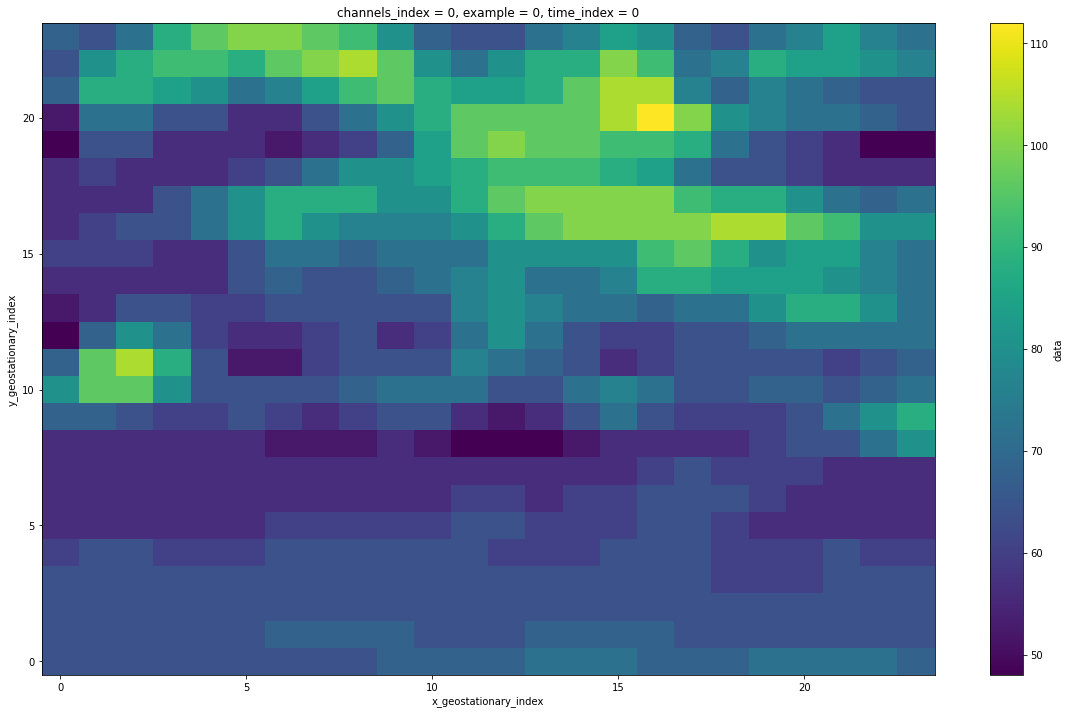

In [26]:
(opened["data"].isel(example=0, channels_index=0, time_index=0).astype(np.int16) * 4).plot()

In [60]:
8000/60

133.33333333333334

In [11]:
%%time



with fsspec.open(DST_PATH / filename.name, mode="wb") as file:
    satellite_dataset.to_netcdf(
        file,
        mode="w",
        engine="h5netcdf",
        encoding=encoding,
        compute=True,
    )

lossless=False


OSError: [Errno 29] Seek only available in read mode

For four timesteps:

| algo | runtime | size | MAE | PSNR |
|------|---------|-----------|---|----|
| bz2, level=5, int16 | 6.8 sec | 2.9 MB | | |
| jpex-xl, distance=0, effort=7, uint16 | 8.15 sec | 2.2 MB | | |
| jpex-xl, distance=0, effort=9, uint16 | 29 sec | 2.2 MB | 0 | |
| jpex-xl, distance=0, effort=9, float16 | 27.5 sec | 2.2 MB | 0 | 100 |
| jpex-xl, distance=1, effort=7, uint16 | 8.2 sec | 2.2 MB | | |
| jpeg-xl, distance=0.5, effort=9, uint8 | 16.2 s | 0.6 MB | 0.378 | 51.27 |
| jpeg-xl, distance=0.5, effort=8, uint8 | 7.8 s | 0.6 MB | 0.379 | 51.26 |
| jpeg-xl, distance=0.5, effort=7, uint8 | 6.8 s | 0.6 MB | 0.365 | 51.51 |
| jpeg-xl, distance=0.0, effort=7, uint8 | 8.58 s | 1.3 MB | | |
| jpeg-xl, distance=0.0, effort=9, uint8 | 18.2 s | 1.3 MB | | |
| jpeg-xl, distance=1.0, effort=9, uint8 | 12.8 s | 0.4 MB | 0.593 | |
| jpeg-xl, distance=0.1, effort=9, uint8 | 35.6 s | 1.8 MB | | |
| jpeg-xl, distance=0.2, effort=8, uint8 | 10.6 s | 1.2 MB | 0.136 |56.73 |
| jpeg-xl, distance=0.3, effort=8, uint8 | 7.8 s | 0.86 MB | 0.242 | 53.99 |
| jpeg-xl, distance=0.4, effort=8, uint8 | 8.08 s | 0.69 MB | 0.317 | 52.45 |
| jpeg-xl, distance=0.6, effort=8, float16 | 7.8 s | 0.74 MB  | 0.376; or 0.353 after rounding | 52.34 |
| jpeg-xl, distance=0.5, effort=7, float16 | 5.43 s | 0.87 MB | 0.324 | 53.85 |
| jpeg-xl, distance=0.4, effort=8, float16 | 7.8 s | 1.1 MB | 0.2749 | 55.17 |
| jpeg-2k, level=100, uint8 | 4.9 s | 1.1 MB | 0.1625  | 56.01 |
| jpeg-2k, level=80, uint8 | 5.2 s | 1.1 MB | 0.163 | 55.99 |
| jpeg-2k, level=65, uint8 | 5.0 s | 1.0 MB | 0.178 | 55.55 |
| jpeg-2k, level=60, uint8 | 5.0 s | 0.9 MB | 0.210 | 54.78 |
| jpeg-2k, level=55, uint8 | 5.0 s | 0.75 MB | 0.2935 | 53.01 |
| jpeg-2k, level=50, uint8 | 4.9 s | 0.5 MB | 0.468 | 49.79 |
| bz2, level=5, uint8 | 5.64 sec | 1.8 MB | | |

Some conclusions:

* TL;DR: Let's use jpeg-xl, distance=0.6, effort=8, float16. Need to map values to the range [0, 1], and use `JpegXlFuture` wrapper.
* In the numbers above, JPEG-2000 actually might look a tiny bit better than JPEG-XL! But the imagecodecs implementation of JPEG-2000 doesn't appear to support float16 or float32 (so no representation of NaNs).

In [12]:
418+253+83+0.3

754.3

In [13]:
OUTPUT_ZARR_PATH = f"gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/test_jpeg_xl_compression/jpeg_xl_distance_0.6_effort_8_float16.zarr"

In [14]:
opened = xr.open_dataset(
    OUTPUT_ZARR_PATH, engine="zarr", mode="r", 
    backend_kwargs={"storage_options": {"token": "google_default"}})

lossless=None
lossless=None


In [15]:
import math

In [16]:
def psnr(img1, img2):
    # Adapted from https://dsp.stackexchange.com/a/50704
    img1 = np.float32(img1).flatten()
    img2 = np.float32(img2).flatten()
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [17]:
psnr(original_float16["data"], opened["data"])

NameError: name 'original_float16' is not defined

In [ ]:
opened["data"].isel(time=0).plot();

In [ ]:
(opened["data"].isel(time=0, x=slice(500, 900), y=slice(300, 700))).plot();

In [ ]:
original_float16["data"].sel(time=DATETIME_TO_PLOT).isel(x=slice(500, 900), y=slice(300, 700)).plot();

In [ ]:
diff = ((opened["data"].astype(np.float32)) - (original_float16["data"].astype(np.float32)))
diff.isel(time=0).plot();

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
np.abs(diff).mean().compute().values

In [ ]:
ax = plt.axes()
ax.hist(diff.values.flatten(), bins=np.arange(-0.02, 0.021, 0.001))
ax.set_title("errors per pixel (compressed image minus original image")
ax.set_ylabel("number of pixels")
ax.set_xlabel("error");

In [ ]:
TIME_I = 0
ax = plt.axes()
ax.hist(
    (
        opened["data"].isel(time=TIME_I).values.flatten(),
        original_float16["data"].isel(time=TIME_I).values.flatten(),
    ),
    bins=64,
    align='left',
    label=["compressed", "original"]
);
ax.legend()
ax.set_title("Histogram of pixel values for image at " + pd.Timestamp(opened["data"].isel(time=TIME_I).time.values).strftime("%Y-%m-%d %H:%M"));

In [ ]:
ax = plt.axes()
TIME_I = 0
ax.scatter(
    x=original_float16["data"].isel(time=TIME_I).values.flatten(),
    y=opened["data"].isel(time=TIME_I).values.flatten(),
    alpha=0.3,
    linewidth=0,
    s=2,
);
ax.grid(visible=True)
ax.set_title("Gamma curve (mapping from original pixel values to compressed pixel values)")
ax.set_xlabel("original image pixel values")
ax.set_ylabel("compressed image pixel values");